In [1]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')

In [2]:
import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint


In [3]:
import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


In [4]:
fig_save = Path("./../figures/")

In [5]:
from pathlib import Path

process_path = Path('./../data/processed/')
# p = Path('./')
prmasr_nc = {}
prmasr_nc["L"] = {}
prmasr_nc["S"] = {}
prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
prmasr_nc

{'L': {'18': [PosixPath('../data/processed/ecological_masks/18prmasr0302_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0303_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0304_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0305_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0306_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0307_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0308_L.nc')],
  '19': [PosixPath('../data/processed/ecological_masks/19prmasr1002_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1003_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1004_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1006_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1007_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1008_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1009_L.nc')]},


In [6]:

colors_hex = ["#4DB65B", "#425DAA", "#F1EB58", "#A4AA56", "#49B0AD", "#A95052", "#74C044"]
color_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

ecological_colors = {}
for name, color_hex in zip(color_names, colors_hex):
    ecological_colors[name] = matplotlib.colors.to_rgb(color_hex)
    
print(ecological_colors)


{'Avadlek': (0.30196078431372547, 0.7137254901960784, 0.3568627450980392), 'Guillemot': (0.25882352941176473, 0.36470588235294116, 0.6666666666666666), 'Herschel': (0.9450980392156862, 0.9215686274509803, 0.34509803921568627), 'Komakuk': (0.6431372549019608, 0.6666666666666666, 0.33725490196078434), 'Orca': (0.28627450980392155, 0.6901960784313725, 0.6784313725490196), 'Plove+Jae': (0.6627450980392157, 0.3137254901960784, 0.3215686274509804), 'Thrasher': (0.4549019607843137, 0.7529411764705882, 0.26666666666666666)}


In [39]:
def combine_netcdf(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

def combine_netcdf_bands(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim='wavelength')
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

In [8]:
ds_l = combine_netcdf(prmasr_nc["L"]["18"][1], prmasr_nc["L"]["19"][1])
ds_s = combine_netcdf(prmasr_nc["S"]["18"][1], prmasr_nc["S"]["19"][1])
ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
ds_s["aoi"] = np.rad2deg(ds_s["aoi"])

In [9]:
from rasterio.enums import Resampling

ds_1 = xr.open_dataset(prmasr_nc["L"]["18"][1])
# ds_1_wgs = ds_1.rio.reproject('epsg:4326',resampling=Resampling.bilinear)
 # "epsg:4326"
ds_1["offnadir"] = np.rad2deg(ds_1["offnadir"])
ds_1["aoi"] = np.rad2deg(ds_1["aoi"])  
ds_1

<xarray.Dataset>
Dimensions:          (band: 1, x: 5470, y: 13530)
Coordinates:
    mask_valid       (y, x) int8 ...
    mask_Avadlek     (y, x) int8 ...
    mask_Guillemot   (y, x) int8 ...
    mask_Herschel    (y, x) int8 ...
    mask_Komakuk     (y, x) int8 ...
    mask_Orca        (y, x) int8 ...
    mask_Plove_+Jae  (y, x) int8 ...
    mask_Thrasher    (y, x) int8 ...
  * y                (y) float64 7.727e+06 7.727e+06 ... 7.714e+06 7.714e+06
  * x                (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
  * band             (band) int32 1
    wavelength       (band) float64 ...
    spatial_ref      int32 ...
Data variables:
    offnadir         (band, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    entropy          (band, y, x) float64 ...
    anisotropy       (band, y, x) float64 ...
    alpha            (band, y, x) float64 ...
    p_hhvv           (band, y, x) float32 ...
    ph_diff_hhvv     (band, y, x) float32 ...
    aoi              (band, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [40]:
# ds_l_s = combine_netcdf_bands(prmasr_nc["L"]["18"][1], prmasr_nc["S"]["18"][1])

ValueError: wavelength already exists as coordinate or variable name.

In [ ]:
ds_l_s

In [26]:


for file_path in zip(prmasr_nc["L"]["18"][0:1]):
    print(file_path)
    

def process_range_profile(netcdf_path_l, netcdf_path_s, save_path):
    ds_l = xr.open_dataset(netcdf_path_l)
    ds_s = xr.open_dataset(netcdf_path_s)
    # ds_1_wgs = ds_1.rio.reproject('epsg:4326',resampling=Resampling.bilinear)
    # "epsg:4326"
    ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
    ds_l["aoi"] = np.rad2deg(ds_l["aoi"]) 
    
    ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
    ds_s["aoi"] = np.rad2deg(ds_s["aoi"]) 
    
    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    df_l = pd.DataFrame([], columns=["UnitName", "offnadir", "entropy", "alpha", 'p_hhvv', 'ph_diff_hhvv', 'band'])
    df_s = pd.DataFrame([], columns=["UnitName", "offnadir", "entropy", "alpha", 'p_hhvv', 'ph_diff_hhvv', 'band'])
    
    for UnitName, UnitMask in zip(unit_names, unit_masks):
        ds_l_masked = ds_l.where(ds_l['mask_'+UnitMask] == 1)
        ds_s_masked = ds_s.where(ds_s['mask_'+UnitMask] == 1)
        arr_l = ds_l_masked.offnadir.data
        arr_l[arr_l == 0] = 'nan'
        arr_s = ds_s_masked.offnadir.data
        arr_s[arr_s == 0] = 'nan'
        
        offnadir_profile = np.nanmean(arr, axis=1).flatten()
        entropy_profile = np.nanmean(df_masked.entropy.data, axis=1).flatten()
        alpha_profile = np.nanmean(df_masked.alpha.data, axis=1).flatten()
        p_hhvv_profile = np.nanmean(df_masked.p_hhvv.data, axis=1).flatten()
        ph_diff_hhvv_profile = np.nanmean(df_masked.ph_diff_hhvv.data, axis=1).flatten()
        print(UnitName)
        # UnitName
        UnitName_list = np.repeat(UnitName, len(offnadir_profile))

        df_tmp = pd.DataFrame(
            [(UnitName_list, offnadir_profile, entropy_profile, alpha_profile, p_hhvv_profile, ph_diff_hhvv_profile)],
            columns=["UnitName", "offnadir", "entropy", "alpha", 'p_hhvv', 'ph_diff_hhvv'])
        df_tmp = df_tmp.apply(pd.Series.explode).reset_index()

        df = df.append(df_tmp)
        
    g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0, 1), 
                      palette=ecological_colors, hue_order=unit_names) 
    g.map(sns.histplot, "offnadir", "entropy", bins=100)
    
    
    g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0, 90), 
                      palette=ecological_colors, hue_order=unit_names) 
    g.map(sns.histplot, "offnadir", "alpha", bins=100)
    
    
    g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0.5, 2), 
                      palette=ecological_colors, hue_order=unit_names) 
    g.map(sns.histplot, "offnadir", "p_hhvv", bins=100)
    
    
    g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(-20, 40), 
                      palette=ecological_colors, hue_order=unit_names) 
    g.map(sns.histplot, "offnadir", "ph_diff_hhvv", bins=100)
    

(PosixPath('../data/processed/ecological_masks/18prmasr0302_L.nc'),)


In [16]:
import warnings
warnings.filterwarnings("ignore")  

unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
df = pd.DataFrame([], columns=["UnitName", "offnadir", "entropy", "alpha", 'p_hhvv', 'ph_diff_hhvv'])

for UnitName, UnitMask in zip(unit_names, unit_masks):
    ds_1_masked = ds_1.where(ds_1['mask_'+UnitMask] == 1)
    arr = ds_1_masked.offnadir.data
    arr[arr == 0] = 'nan'
    offnadir_profile = np.nanmean(arr, axis=1).flatten()
    entropy_profile = np.nanmean(ds_1_masked.entropy.data, axis=1).flatten()
    alpha_profile = np.nanmean(ds_1_masked.alpha.data, axis=1).flatten()
    p_hhvv_profile = np.nanmean(ds_1_masked.p_hhvv.data, axis=1).flatten()
    ph_diff_hhvv_profile = np.nanmean(ds_1_masked.ph_diff_hhvv.data, axis=1).flatten()
    print(UnitName)
    # UnitName
    UnitName_list = np.repeat(UnitName, len(offnadir_profile))
    
    df_tmp = pd.DataFrame(
        [(UnitName_list, offnadir_profile, entropy_profile, alpha_profile, p_hhvv_profile, ph_diff_hhvv_profile)],
        columns=["UnitName", "offnadir", "entropy", "alpha", 'p_hhvv', 'ph_diff_hhvv'])
    df_tmp = df_tmp.apply(pd.Series.explode).reset_index()

    df = df.append(df_tmp)

df

Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher


,UnitName,offnadir,entropy,alpha,p_hhvv,ph_diff_hhvv,index
0,Avadlek,NaN,NaN,NaN,NaN,NaN,0.0
1,Avadlek,NaN,NaN,NaN,NaN,NaN,0.0
2,Avadlek,NaN,NaN,NaN,NaN,NaN,0.0
3,Avadlek,NaN,NaN,NaN,NaN,NaN,0.0
4,Avadlek,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
5465,Thrasher,NaN,NaN,NaN,NaN,NaN,0.0
5466,Thrasher,NaN,NaN,NaN,NaN,NaN,0.0
5467,Thrasher,NaN,NaN,NaN,NaN,NaN,0.0
5468,Thrasher,NaN,NaN,NaN,NaN,NaN,0.0


In [15]:
# df.set_index('UnitName')
df_tmp.dropna()

,index,UnitName,offnadir,entropy,alpha,p_hhvv,ph_diff_hhvv
127,0,Thrasher,1.50788,0.367818,23.9536,1.87795,-1.15898
128,0,Thrasher,1.37714,0.160019,18.211,0.47122,2.98572
129,0,Thrasher,1.24673,0.310084,16.9347,0.788075,13.2666
130,0,Thrasher,1.39531,0.423714,20.2841,0.81616,1.96539
131,0,Thrasher,1.34637,0.405529,19.2157,0.828799,3.28483
...,...,...,...,...,...,...,...
5362,0,Thrasher,9.94789,0.50437,30.4286,1.04997,20.2426
5363,0,Thrasher,10.8409,0.471967,28.4341,1.12703,17.6785
5364,0,Thrasher,11.6101,0.451553,27.5408,1.06847,20.8895
5365,0,Thrasher,11.9644,0.404608,23.3429,0.88804,19.8731


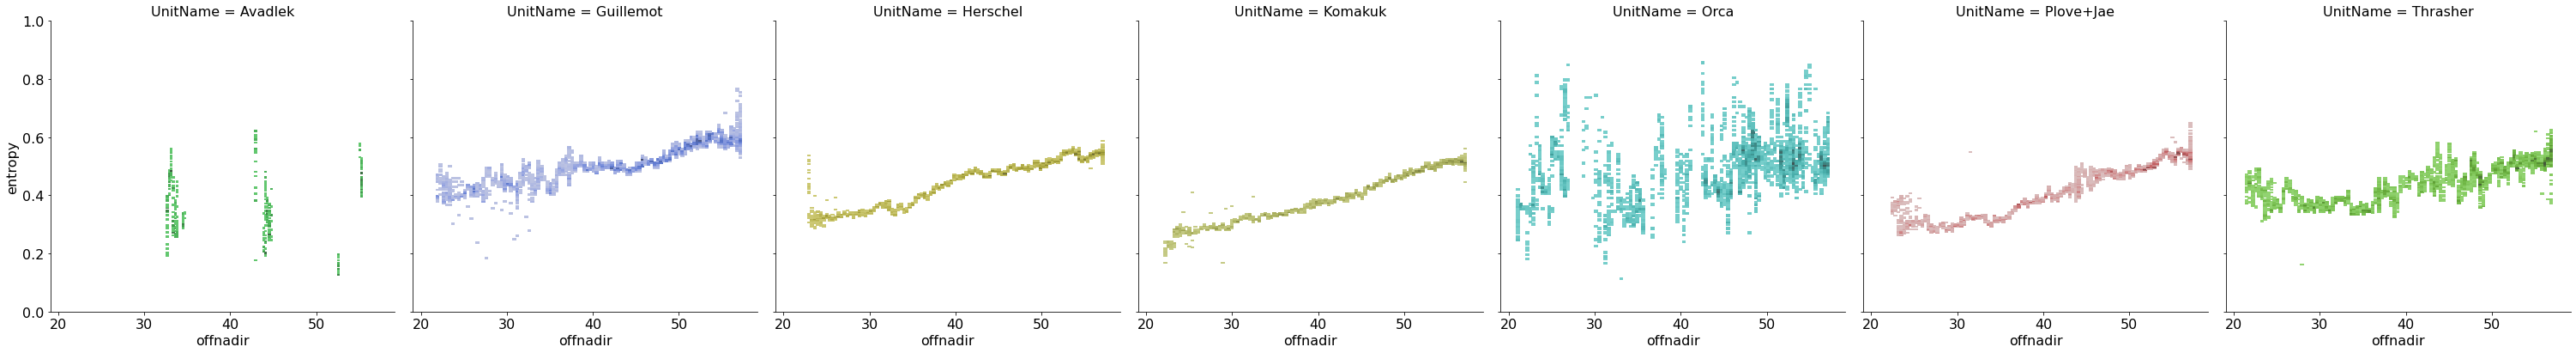

In [30]:
g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0, 1), palette=ecological_colors, hue_order=unit_names) # col="time",  row="sex",
g.map(sns.histplot, "offnadir", "entropy", bins=100)

In [ ]:
g.savefig()

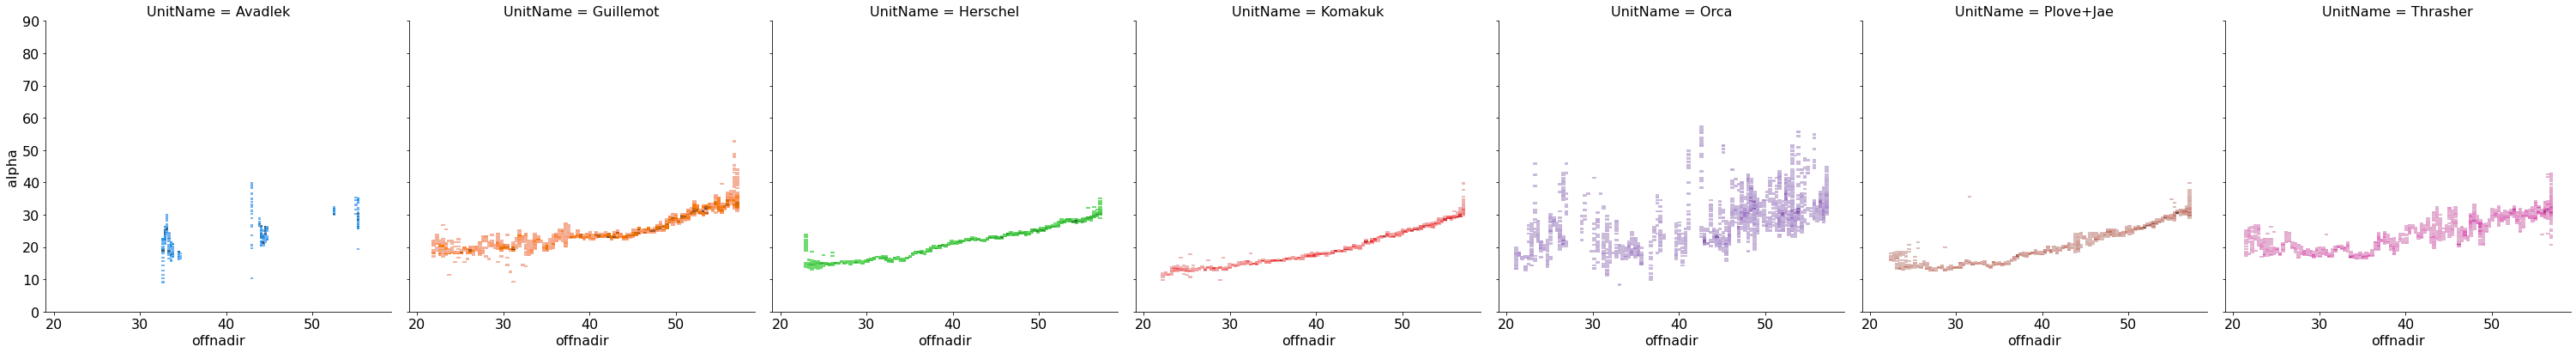

In [21]:
g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0, 90)) # col="time",  row="sex",
g.map(sns.histplot, "offnadir", "alpha", bins=100)

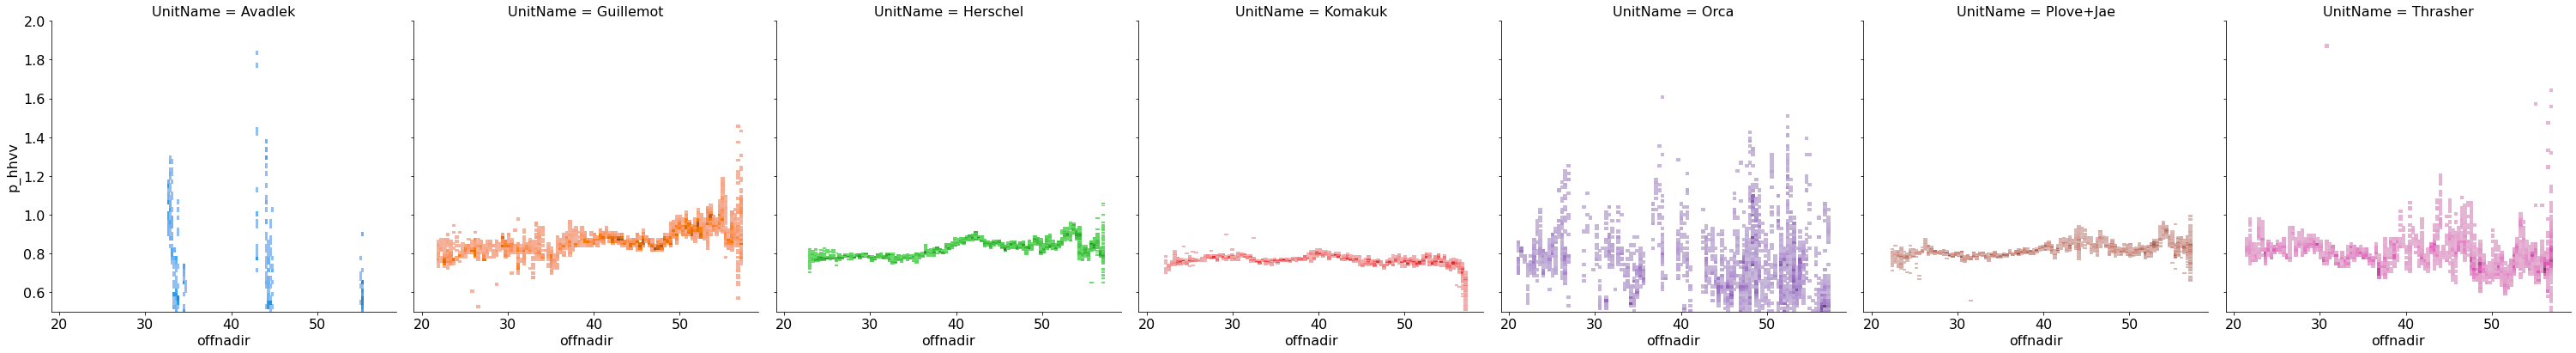

In [22]:
g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(0.5, 2)) # col="time",  row="sex",
g.map(sns.histplot, "offnadir", "p_hhvv", bins=100)

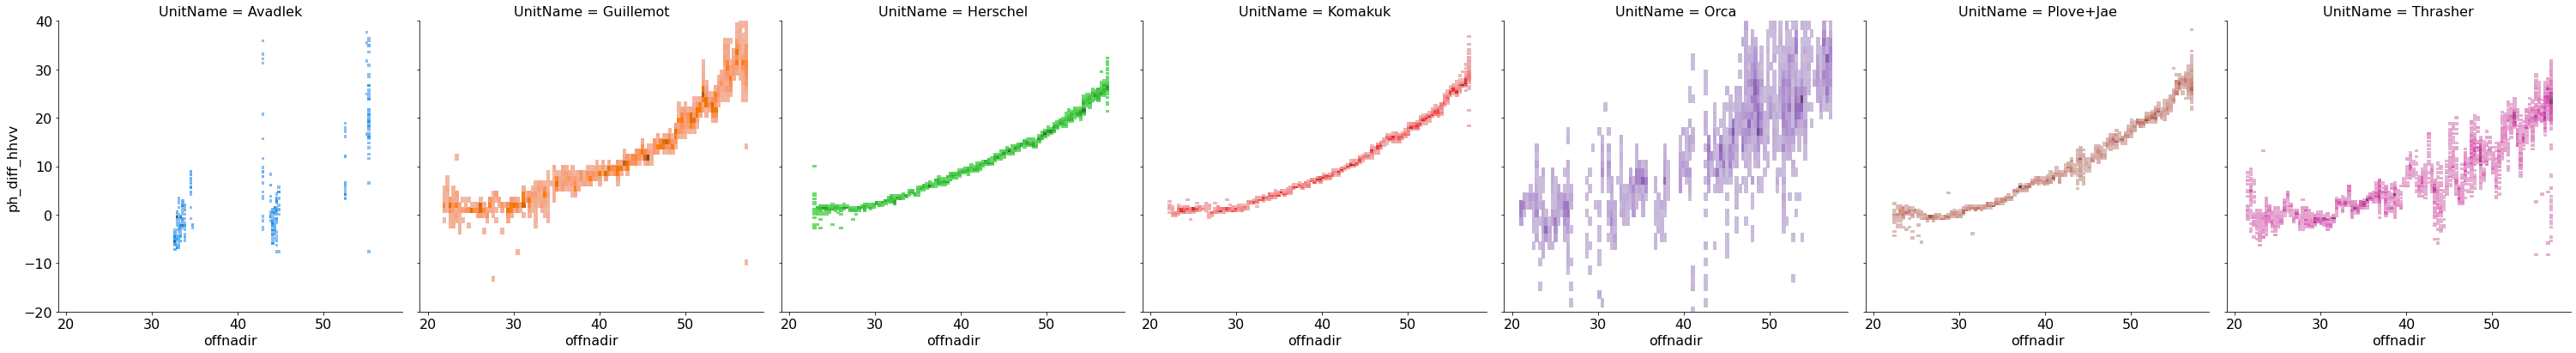

In [24]:
g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName", height=6, ylim=(-20, 40)) # col="time",  row="sex",
g.map(sns.histplot, "offnadir", "ph_diff_hhvv", bins=100)

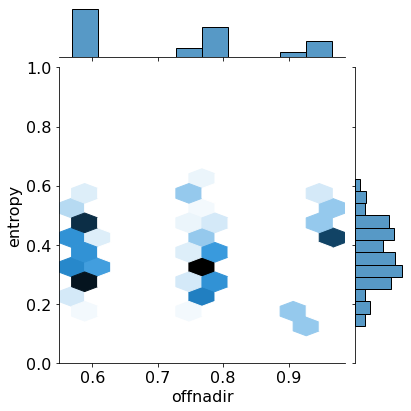

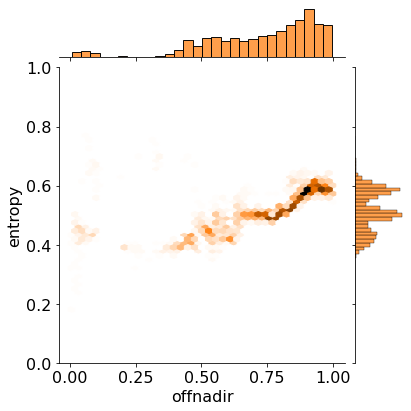

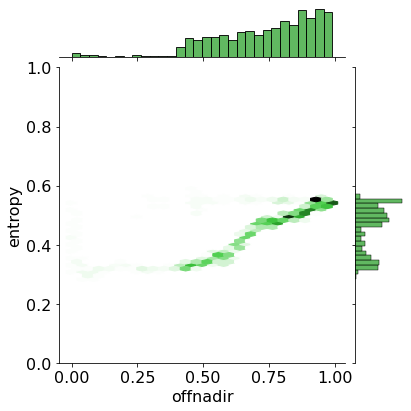

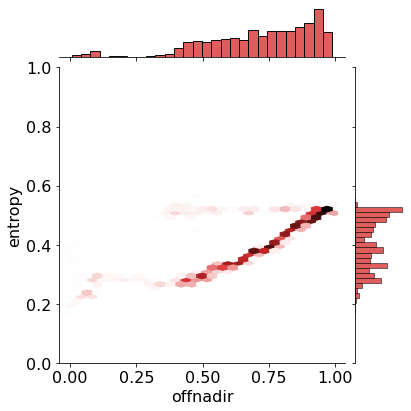

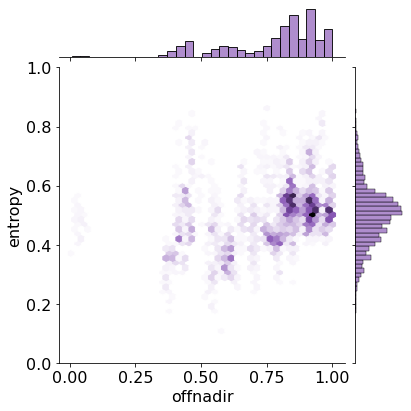

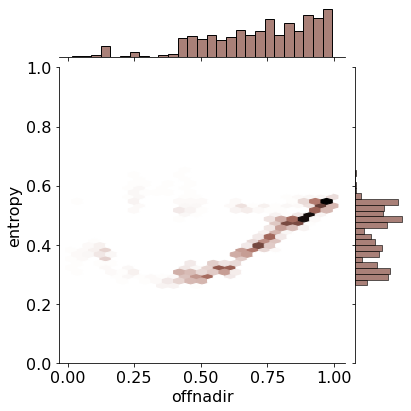

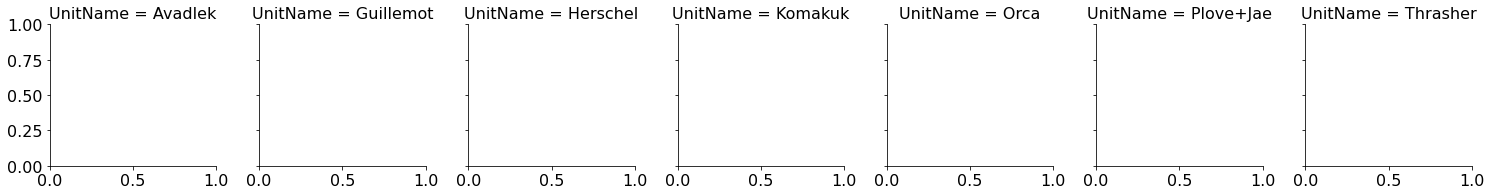

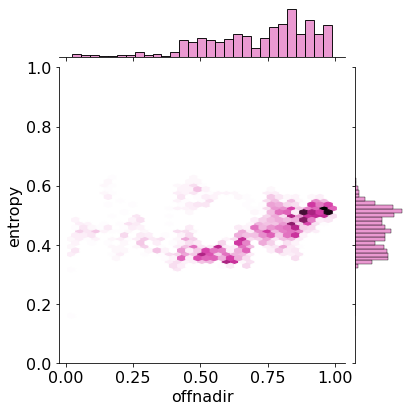

In [95]:
g = sns.FacetGrid(data=df, col="UnitName", hue="UnitName",  ylim=(0, 1))
g.map_dataframe(sns.jointplot, x="offnadir", y="entropy", kind="hex",ylim=(0, 1), bins=100)

In [91]:
g.facet_axis

<bound method FacetGrid.facet_axis of <seaborn.axisgrid.FacetGrid object at 0x7f8e57e23820>>

AttributeError: 'PolyCollection' object has no property 'hue'

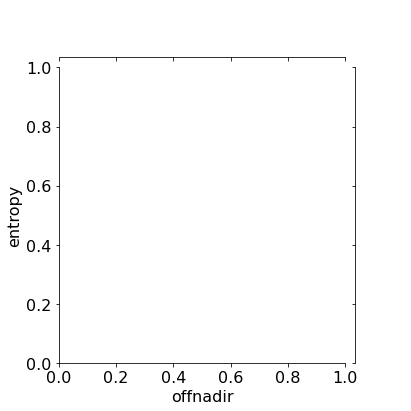

In [83]:

g = sns.jointplot(data=df.set_index('UnitName'), x='offnadir',  y='entropy', kind="hex", hue="UnitName")
# g = sns.JointGrid(x, y, ratio=100)
#g.plot_joint(sns.regplot)
#g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
g.ax_marg_x.remove()
g.ax_marg_y.remove()

In [ ]:
unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

dfObj = pd.DataFrame(columns=['User_ID', 'UserName', 'Action'])


for UnitName, UnitMask in zip(unit_names, unit_masks):
    print(UnitName, UnitMask)
    ds_l_df.loc[ds_l_df['mask_' + UnitMask ]==1,'UnitName'] = UnitName
    ds_s_df.loc[ds_s_df['mask_' + UnitMask ]==1,'UnitName'] = UnitName


<ipython-input-34-b92d31183149>:1: RuntimeWarning: Mean of empty slice
  g = sns.jointplot(x=(np.nanmean(ds_1_masked.offnadir.data, axis=1).flatten()),  y=np.nanmean(ds_1_masked.entropy.data, axis=1).flatten(), kind="hex",)


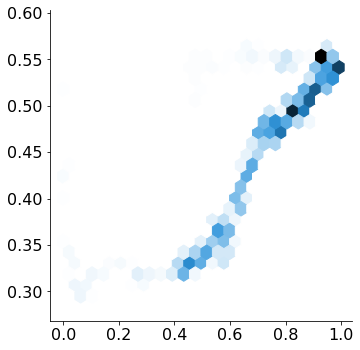

In [34]:
g = sns.jointplot(x=(np.nanmean(ds_1_masked.offnadir.data, axis=1).flatten()),  y=np.nanmean(ds_1_masked.entropy.data, axis=1).flatten(), kind="hex",)
# g = sns.JointGrid(x, y, ratio=100)
#g.plot_joint(sns.regplot)
#g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
g.ax_marg_x.remove()
g.ax_marg_y.remove()

<ipython-input-36-9cff5c86d365>:1: RuntimeWarning: Mean of empty slice
  g = sns.jointplot(x=(np.nanmean(ds_1_masked.offnadir.data, axis=1).flatten()),  y=np.nanmean(ds_1_masked.entropy.data, axis=1).flatten(), kind="scatter",)


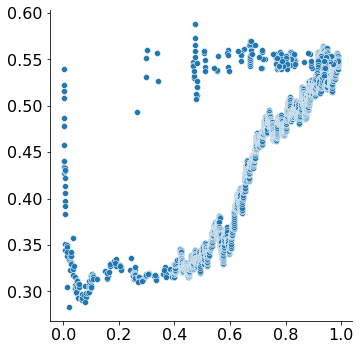

In [36]:
g = sns.jointplot(x=(np.nanmean(ds_1_masked.offnadir.data, axis=1).flatten()),  y=np.nanmean(ds_1_masked.entropy.data, axis=1).flatten(), kind="scatter",)
# g = sns.JointGrid(x, y, ratio=100)
#g.plot_joint(sns.regplot)
#g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
g.ax_marg_x.remove()
g.ax_marg_y.remove()

In [31]:
g.ax_marg_x.remove()

In [11]:
ds_1

<xarray.Dataset>
Dimensions:          (band: 1, x: 5470, y: 13530)
Coordinates:
    mask_valid       (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Avadlek     (y, x) int8 ...
    mask_Guillemot   (y, x) int8 ...
    mask_Herschel    (y, x) int8 ...
    mask_Komakuk     (y, x) int8 ...
    mask_Orca        (y, x) int8 ...
    mask_Plove_+Jae  (y, x) int8 ...
    mask_Thrasher    (y, x) int8 ...
  * y                (y) float64 7.727e+06 7.727e+06 ... 7.714e+06 7.714e+06
  * x                (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
  * band             (band) int32 1
    wavelength       (band) float64 ...
    spatial_ref      int32 ...
Data variables:
    offnadir         (band, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    entropy          (band, y, x) float64 ...
    anisotropy       (band, y, x) float64 ...
    alpha            (band, y, x) float64 ...
    p_hhvv           (band, y, x) float32 ...
    ph_diff_hhvv     (band, y, x) float32 ...
    aoi              (band, y, x) float32 ...

In [14]:
ds_1_t = ds_1.transpose('band', 'y', 'x')  # set dim order to as expected by rioxarray i.e. (band,y,x)
ds_1_t

<xarray.Dataset>
Dimensions:          (band: 1, x: 5470, y: 13530)
Coordinates:
    mask_valid       (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mask_Avadlek     (y, x) int8 ...
    mask_Guillemot   (y, x) int8 ...
    mask_Herschel    (y, x) int8 ...
    mask_Komakuk     (y, x) int8 ...
    mask_Orca        (y, x) int8 ...
    mask_Plove_+Jae  (y, x) int8 ...
    mask_Thrasher    (y, x) int8 ...
  * y                (y) float64 7.727e+06 7.727e+06 ... 7.714e+06 7.714e+06
  * x                (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
  * band             (band) int32 1
    wavelength       (band) float64 0.2262
    spatial_ref      int32 0
Data variables:
    offnadir         (band, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    entropy          (band, y, x) float64 ...
    anisotropy       (band, y, x) float64 ...
    alpha            (band, y, x) float64 ...
    p_hhvv           (band, y, x) float32 ...
    ph_diff_hhvv     (band, y, x) float32 ...
    aoi              (band, y, x) float32 ...

In [ ]:
ds_1.drop('offnadir').rio.reproject('epsg:4326',resampling=Resampling.bilinear)


In [ ]:
#create unique list of names
UniqueNames = data.Names.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.Names == key]